In [23]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [24]:
import numpy as np

data_new = data.copy()
data_new['speed3'] = data_new['speed']**3
alpha = np.arctan(data_new['slope'])
data_new['speed_sin_alpha'] = data_new['speed']*np.sin(alpha)
data_new["acceleration"].clip(lower=0)
data_new['speed_acceleration'] = data_new['speed']*data_new['acceleration']

data_new = data_new.drop(columns=['heart-rate', 'cadence', 'acceleration', 'slope'])

In [25]:
data_new['speed_sin_alpha'].mean()

-0.002709709612566326

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.pipeline import make_pipeline

linear_model = make_pipeline(
    StandardScaler(),
    RidgeCV(
        #alphas=[1e-3, 1e-2, 1e-1, 1], 
        #scoring="neg_mean_absolute_error"
    )
)

cv = ShuffleSplit(n_splits=4)
cv_results = cross_validate(
    linear_model, data_new, target,
    return_estimator=True,
    return_train_score=True,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

In [27]:
cv_results['test_score'].mean()

-72.6626738974231

In [28]:
cv_results

{'fit_time': array([0.04168439, 0.02014804, 0.01762247, 0.01753449]),
 'score_time': array([0.00454617, 0.00221658, 0.00225306, 0.0024395 ]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())]),
  Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())])],
 'test_score': array([-73.58063061, -72.36365542, -73.78092695, -70.92548261]),
 'train_score': array([-72.13926016, -72.3018189 , -72.15706767, -72.49506727])}

In [29]:
print(cv_results['estimator'][0]['ridgecv'].coef_)
data_new.columns #feature_names_in_


[32.08212217  5.16827924 78.3175329  12.3357443 ]


Index(['speed', 'speed3', 'speed_sin_alpha', 'speed_acceleration'], dtype='object')

In [30]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_model = HistGradientBoostingRegressor(
    max_iter=1000,
    early_stopping=True
)

cv_results_hist = cross_validate(
    hist_model, data, target,
    return_estimator=True,
    return_train_score=True,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

cv_results_hist['test_score'].mean()

-45.15180189929053

In [31]:

print(-cv_results_hist['train_score'].mean())
print(-cv_results_hist['test_score'].mean())

print(-cv_results['train_score'].mean())
print(-cv_results['test_score'].mean())



40.679051893858514
45.15180189929053
72.27330349976168
72.6626738974231


In [32]:
import numpy as np

unique_ride_dates = np.unique(data.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


In [33]:
group = data_new.index.date
group_idx = pd.factorize(group)

print(group)
print(group_idx)

[datetime.date(2020, 8, 18) datetime.date(2020, 8, 18)
 datetime.date(2020, 8, 18) ... datetime.date(2020, 9, 13)
 datetime.date(2020, 9, 13) datetime.date(2020, 9, 13)]
(array([0, 0, 0, ..., 3, 3, 3]), array([datetime.date(2020, 8, 18), datetime.date(2020, 8, 20),
       datetime.date(2020, 8, 26), datetime.date(2020, 9, 13)],
      dtype=object))


In [34]:
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()


In [35]:
from sklearn.model_selection import cross_val_score
cv_results_group = cross_validate(
    linear_model, data_new, target,
    return_estimator=True,
    return_train_score=True,
    cv=cv,
    groups=group_idx[0],
    scoring="neg_mean_absolute_error"
)

cv_results_hist_group = cross_validate(
    hist_model, data_new, target,
    return_estimator=True,
    return_train_score=True,
    cv=cv,
    groups=group_idx[0],
    scoring="neg_mean_absolute_error"
)

In [37]:
print(-cv_results_hist_group['train_score'].mean())
print(-cv_results_hist_group['test_score'].mean())

print(-cv_results_group['train_score'].mean())
print(-cv_results_group['test_score'].mean())

62.122094968493045
67.25294447467786
72.10385775733243
72.8673712060876


In [38]:
print(-cv_results['train_score'].mean())
print(-cv_results['test_score'].mean())

print(-cv_results_group['train_score'].mean())
print(-cv_results_group['test_score'].mean())

72.27330349976168
72.6626738974231
72.10385775733243
72.8673712060876


In [39]:
print(-cv_results_hist['train_score'].mean())
print(-cv_results_hist['test_score'].mean())

print(-cv_results_hist_group['train_score'].mean())
print(-cv_results_hist_group['test_score'].mean())

40.679051893858514
45.15180189929053
62.122094968493045
67.25294447467786


In [41]:
cv = LeaveOneGroupOut()

train_indices, test_indices = list(cv.split(data, target, groups=group_idx[0]))[0]

data_linear_model_train = data_new.iloc[train_indices]
data_linear_model_test = data_new.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

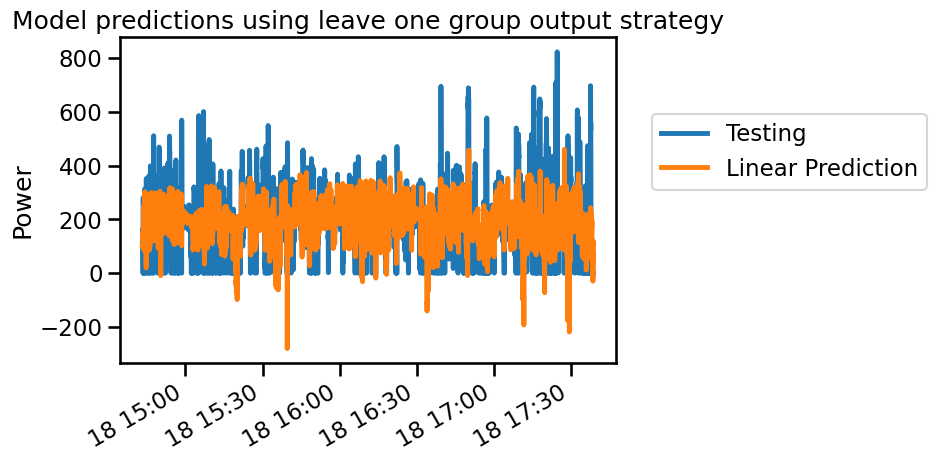

In [45]:
import matplotlib.pyplot as plt

# linear model
linear_model.fit(data_linear_model_train, target_train)
linear_target_predicted = linear_model.predict(data_linear_model_test)

linear_target_predicted = pd.Series(linear_target_predicted, index=target_test.index)

# hist model
hist_model.fit(data_train, target_train)
hist_target_predicted = hist_model.predict(data_test)

hist_target_predicted = pd.Series(hist_target_predicted, index=target_test.index)


#target_train.plot(label="Linear Training")
target_test.plot(label="Testing")
linear_target_predicted.plot(label="Linear Prediction")

plt.ylabel("Power")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using leave one group output strategy")

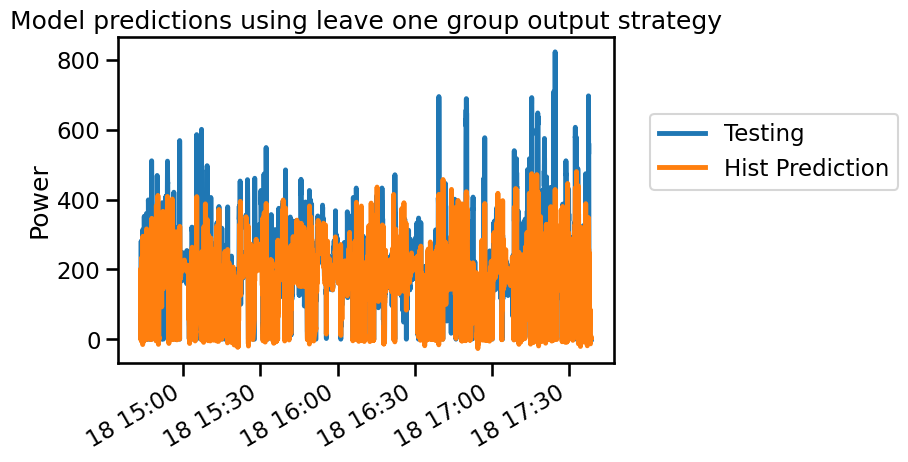

In [46]:
#target_train.plot(label="Linear Training")
target_test.plot(label="Testing")
hist_target_predicted.plot(label="Hist Prediction")

plt.ylabel("Power")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using leave one group output strategy")

In [47]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(linear_target_predicted, target_test))
print(mean_absolute_error(hist_target_predicted, target_test))

72.2510931327739
47.56845814610118


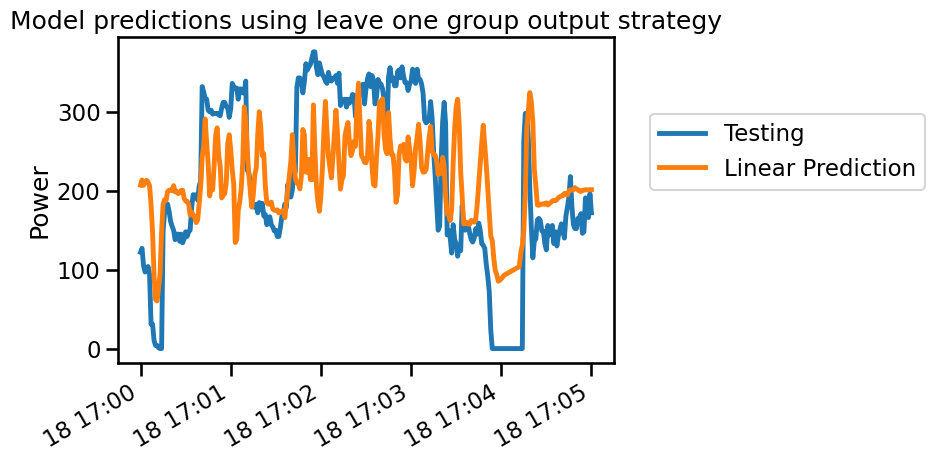

In [50]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]


# linear model
linear_target_predicted_subset = linear_model.predict(data_test_linear_model_subset)
linear_target_predicted_subset = pd.Series(linear_target_predicted_subset, index=target_test_subset.index)

# hist model
hist_target_predicted_subset = hist_model.predict(data_test_subset)
hist_target_predicted_subset = pd.Series(hist_target_predicted_subset, index=target_test_subset.index)


#target_train.plot(label="Linear Training")
target_test_subset.plot(label="Testing")
linear_target_predicted_subset.plot(label="Linear Prediction")

plt.ylabel("Power")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using leave one group output strategy")

plt.show()


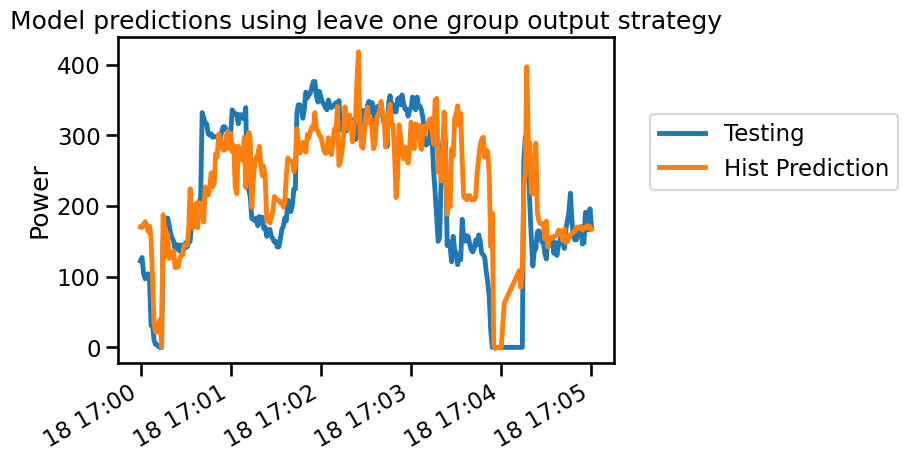

In [51]:
#target_train.plot(label="Linear Training")
target_test_subset.plot(label="Testing")
hist_target_predicted_subset.plot(label="Hist Prediction")

plt.ylabel("Power")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using leave one group output strategy")

In [52]:

print(mean_absolute_error(linear_target_predicted_subset, target_test_subset))
print(mean_absolute_error(hist_target_predicted_subset, target_test_subset))

68.19896192980299
49.94524479609353
